<a href="https://colab.research.google.com/github/dtanwar23/Forecasting-Price-with-LSTM/blob/main/Retail_sales_wit_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load Dataset

As the data coming from Brasil we need to translate the columns names:

Portugese | English
--- | ---
data | Date
venda | Sales
estoque | Stock
preco | price

In [ ]:
df = pd.read_csv("/kaggle/input/retail-sales-forecasting/mock_kaggle.csv", index_col="data")
df = df.rename(columns={'data' : 'Date', 'venda' : 'Sales', 'estoque' : 'Stock', 'preco' : 'Price'})

In [ ]:
df

,Sales,Stock,Price
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29
...,...,...,...
2016-07-27,98,3179,2.39
2016-07-28,108,3071,2.39
2016-07-29,128,4095,2.39


In [ ]:
df.head()

,Sales,Stock,Price
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 937 entries, 2014-01-01 to 2016-07-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   937 non-null    int64  
 1   Stock   937 non-null    int64  
 2   Price   937 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 29.3+ KB


# Data preprocessing

We will then use MinMaxScaler to scale the dataset to the range from 0 to 1. each feature will be scaled indiviually

In [ ]:
values = df.values
scaler = MinMaxScaler()
values = scaler.fit_transform(values)

y_scaler = MinMaxScaler()
y_scaler.fit(df["Sales"].values.reshape(-1,1))

df = pd.DataFrame(values, columns=["Sales", "Stock", "Price"])

In [ ]:
df.head()

,Sales,Stock,Price
0,0.000000,0.687880,0.432886
1,0.129151,0.678196,0.432886
2,0.108856,0.670033,0.432886
3,0.171587,0.657167,0.432886
4,0.177122,0.643885,0.432886


# Split Training and Testing data

As shown in the dataset, there's a new sample every day for two years. so we will take the last month (30 days) as our test data and train over the rest of the data

In [ ]:
test_size = 30  # last month
train = df.iloc[:-test_size, :]
y_train = train["Sales"].to_numpy()
x_train = train.to_numpy()

test  = df.iloc[-test_size:]
y_test = test["Sales"].to_numpy()
x_test = test.to_numpy()

## Generate time series data

We need to generate time series data for the training. for example if we have three arrays <br>
sales (target)    =  [10, 20, 30, 40, 50] <br>
price (feature_1) =  [1, 2, 3, 4, 5] <br>
stock (feature_2) =  [100, 200, 300, 400, 500] <br>

The data sample should contain the [feature_1(t-1), feature_2(t-1), target(t-1)] and try to predict the target at time (t). <br>

[1,100,10] ==> 20 <br>
[2,200,20] ==> 30 <br>
[3,300,30] ==> 40 <br>

And so on

In [ ]:
length = 1
train_generator = TimeseriesGenerator(x_train, y_train, length=length, batch_size=1)
test_generator = TimeseriesGenerator(x_test, y_test, length=length, batch_size=1)

# Build Model and Train

In [ ]:
number_of_features = 3  # (price, stock, sales)
number_of_targets = 1   # (sales)

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape=(length, number_of_features)))
model.add(Dense(number_of_targets))

model.compile(
    optimizer="adam",
    loss="mse"  # Because this is a regression problem
)

# To prevent the model from over fitting over the data
early_stopping = EarlyStopping(monitor="val_loss")


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

#### Important Note

A very important note before training. We need to prevent the "fit" function from shuffeling the data samples as the sequence and the order of the data is very important as we want to catch the changes and trends along the time.

In [ ]:
model.fit(
    train_generator,
    epochs=20,
    callbacks=[early_stopping],
    validation_data=test_generator,
    shuffle=False
)

Epoch 1/20
906/906 [==============================] - 4s 3ms/step - loss: 0.0159 - val_loss: 0.0175


# Evaluation

In [ ]:
model.predict(test_generator)

array([[0.4573965 ],
       [0.32156095],
       [0.2895882 ],
       [0.3564808 ],
       [0.37902707],
       [0.33699748],
       [0.20319097],
       [0.26240927],
       [0.24191894],
       [0.2811619 ],
       [0.32867777],
       [0.43188345],
       [0.28413886],
       [0.32686225],
       [0.4328858 ],
       [0.3240156 ],
       [0.3022102 ],
       [0.2956301 ],
       [0.40496302],
       [0.17984203],
       [0.21331935],
       [0.27550113],
       [0.266857  ],
       [0.19618694],
       [0.29697073],
       [0.30998033],
       [0.31568837],
       [0.37705618],
       [0.502172  ]], dtype=float32)

In [ ]:
predictions = model.predict(test_generator)

Invert the scaled values of the **Sales** data to visualize the final output

In [ ]:
y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))
predictions = y_scaler.inverse_transform(predictions.reshape(-1,1))

Now let's visualize the predicted Sales for the last month vs. the actual Sales values for that month

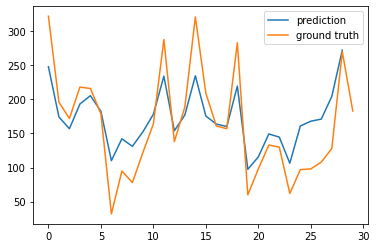

In [ ]:
import matplotlib.pyplot as plt
plt.plot(predictions, label="prediction")
plt.plot(y_test, label="ground truth")
plt.legend()
plt.show()